In [75]:
# Import Necessay Packages
%load_ext autoreload
%autoreload 2
import importlib.util
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
parent_dir = Path.cwd().parent.resolve()
sys.path.append(parent_dir)

In [ ]:
# Import Necessary Modules
from torchgeo.datasets import NAIP

import configs.config as config
from data.dem import KaneDEM
from data.kc import KaneCounty
from data.sampler import BalancedRandomBatchGeoSampler

importlib.reload(config)

In [78]:
MODEL_DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [79]:
def preprocess(sample):
    """Converts image data to float, then normalizes it

    Args:
        sample: a piece of a raster image
    Returns:
        sample image data in float
    """
    if "image" in sample:
        sample["image"] = sample["image"].float() / 255.0
        return sample
    sample["mask"] = sample["mask"].float() / 255.0
    return sample

In [80]:
# Instantiate and combine NAIP and KC shape data
naip = NAIP(config.KC_IMAGE_ROOT, transforms=preprocess)
print(naip.crs)
shape_path = str(Path(config.KC_SHAPE_ROOT) / Path(config.KC_SHAPE_FILENAME))
dataset_config = (
    config.KC_LAYER,
    config.KC_LABELS,
    config.PATCH_SIZE,
    naip.crs,
    naip.res,
)
kc = KaneCounty(shape_path, dataset_config)
print(kc.crs)

dataset = naip & kc
sampler = BalancedRandomBatchGeoSampler(
    config={
        "dataset": dataset,
        "size": config.PATCH_SIZE,
        "batch_size": config.BATCH_SIZE,
        "CRS": dataset.crs,
    }
)

EPSG:26916
EPSG:26916


In [81]:
dem = KaneDEM(paths="/net/projects/cmap/data/kane-county-data/KC_DEM_2017", config=config, crs=naip.crs)

In [82]:
item = next(iter(sampler))

In [83]:
dataset.crs

CRS.from_epsg(26916)

In [84]:
dem[item[0]]["image"].shape

torch.Size([1, 512, 512])

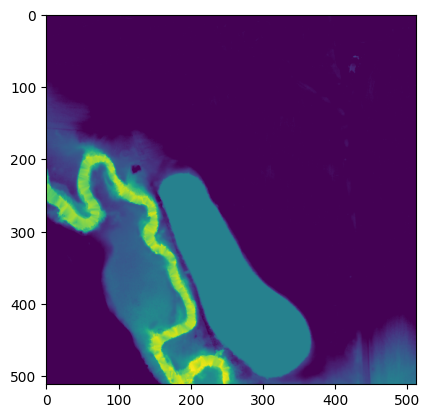

In [85]:
plt.imshow(dem[item[0]]["image"].permute(1, 2, 0))

In [86]:
naip[item[0]]["image"].shape

torch.Size([4, 512, 512])

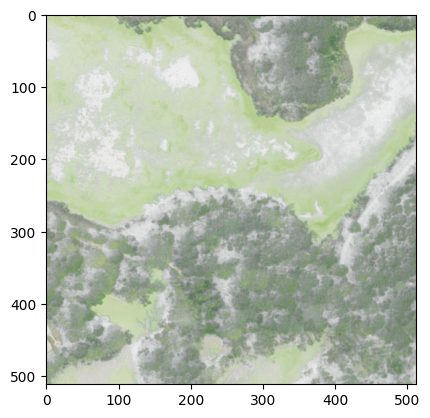

In [89]:
# plotting naip image
image = dataset[item[2]]["image"]
image = image.permute(1, 2, 0)

plt.imshow(image)
plt.show()

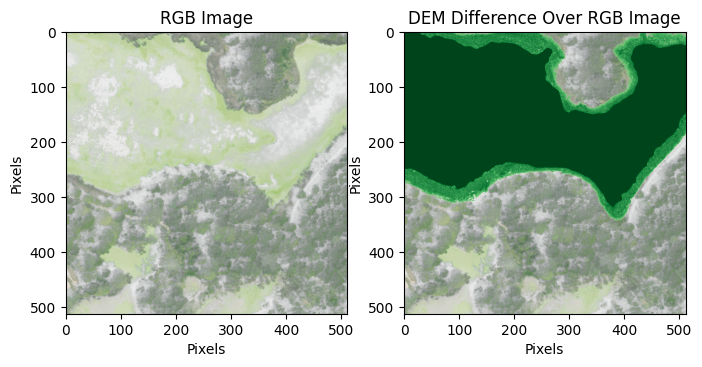

In [92]:
# Converting DEM CRS to NAIP CRS and plotting the corresponding DEM image
with rasterio.open(str(config.KC_DEM_ROOT / Path("Kane2017BE_fill_diff.tif"))) as src:
    i = 2
    bbox = (item[i].minx, item[i].miny, item[i].maxx, item[i].maxy)
    bbox = rasterio.warp.transform_bounds(dataset.crs, src.crs, *bbox)
    window = src.window(*bbox)
    subset = src.read(1, window=window)

    image = dataset[item[i]]["image"]
    image = image.permute(1, 2, 0)

    fig, axes = plt.subplots(1, 2, figsize=(8, 12))

    im1 = axes[0].imshow(image, cmap="terrain")
    axes[0].set_title("RGB Image")
    axes[0].set_xlabel("Pixels")
    axes[0].set_ylabel("Pixels")
    
    im2 = axes[1].imshow(image, cmap="terrain", alpha=1)
    alpha_mask = np.where(np.isclose(subset, 0, atol=1), 0.0, 1.0)
    axes[1].imshow(subset, cmap="Greens", alpha=alpha_mask)
    axes[1].set_title("DEM Difference Over RGB Image")
    axes[1].set_xlabel("Pixels")
    axes[1].set_ylabel("Pixels")
